<a href="https://colab.research.google.com/github/bayjan/idep_demo/blob/master/idepDemo_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducing some parts of an separate study
Here we will try to reproduce PCA plot as shown in **Figure 2A** of this article (https://www.mdpi.com/1422-0067/21/18/6746 ) using some R code. You will need to reproduce using iDEP web-tool the figures 2A, 2C and 3A. Reflect on the (potential) differences between the figures you created and those reported in that article.

This notebook is an adapted version of the longer notebook, which is also in the same repository, at: https://github.com/bayjan/idep_demo/blob/b70070f01d19a13fba94df5842717fe53cf6f77a/idepDemo_clean.ipynb . Thus, it is advised that you first try to reproduce iDEP's default figures using that notebook, because there are more introductory information and here we use completely different data.

Also GitHub repository of iDEP tool is here at:**https://github.com/iDEP-SDSU/idep/tree/master/shinyapps/idep**.

## Learning goals 
* Similar goals as noted in the notebook at: https://github.com/bayjan/idep_demo/blob/b70070f01d19a13fba94df5842717fe53cf6f77a/idepDemo_clean.ipynb
* How well we can reproduce completely different data set

In [1]:
# In our case expression_file is an input file
rnaseq_counts_file = "https://raw.githubusercontent.com/bayjan/idep_demo/master/GSE154074_CA_DN_p38_TG_Lung_with_BLM_raw_counts_corr.csv"
sampleInfoFile="https://raw.githubusercontent.com/bayjan/idep_demo/master/Factors.csv"

### Read relevant information from GitHub

First we need to install **edgeR** R package, which is a Bioconductor package. Thus, we should also have Bioconductor package manager installed. If the next step fails then you need to use another platform such as your PC/laptop, where you can install edgeR package.

In [3]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("edgeR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.12 (BiocManager 1.30.15), R 4.0.5 (2021-03-31)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘limma’, ‘locfit’


Old packages: 'IRkernel', 'cachem', 'devtools', 'dplyr', 'hms', 'openssl',
  'pillar', 'rmarkdown', 'stringi', 'systemfonts', 'tibble', 'xfun'



Now we have the **edgeR** package successfully installed, we can read necessary input files.

In [6]:
library(ggplot2)
library(edgeR)
x1=read.csv(rnaseq_counts_file, row.names=1)
factors1 = read.csv(sampleInfoFile)

Set parameters similar/same to iDEP's default parameter, but you can change the following parameters as you wish.

In [7]:
minCPM=0.5
nLibraries=1
groups = rep(1:6,each=3)

Filter entries based on the predefined parameters. So, there should be at least 1 sample (`nLibraries=1`) with the minimum CPM of 0.5 (`minCPM=0.5`). You can also use the `filterByExpr` function to remove rows that have less than `minCPM` values in a minumum number of `nLibrary` samples.

In [8]:
x1_filtered <- x1[ which( apply( cpm(DGEList(counts = x1,group=groups)),  1, function(y) sum(y>=minCPM)) >=  nLibraries ) , ]
y1_filtered = DGEList(counts=x1_filtered,group=groups)

Normalize the remaining CPM values using the TMM method, which is a trimmed mean of M-values (see Robinson and Oshlack (2010)). After normalization calculate CPM values.

In [9]:
y1_filtered_tmm <- calcNormFactors(y1_filtered)
y1_filtered_tmm_cpm <- cpm(y1_filtered_tmm)

Calculate PCA of CPM values

In [10]:
pca.object <- prcomp(t(y1_filtered_tmm_cpm),scale=T)

You can also try `log2`-transformed values using the following command `pca.object.log <- prcomp(log2(t(y1_filtered_tmm_cpm)+1),scale=T)`. Compare the results of pca objects with the `summary` R function.

In [11]:
pcaData <- as.data.frame(pca.object$x[,1:2]);
tmp=t(factors1)
pcaData = cbind(pcaData,tmp[2:nrow(tmp),])
colnames(pcaData)[3:4] = tmp[1,]

Create a function to create a similar PCA plot to the iDEP's default PCA plot. See `idepDemo_clean.ipynb` notebook for more information on creating R functions.

In [13]:
plotPCA <- function(pcaData){
  percentVar=round(100*summary(pca.object)$importance[2,1:2],0)
  p=ggplot(pcaData, aes(PC1, PC2, color=Genotype, shape = Treatment)) + geom_point(size=5) 
  p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
  p=p+ylab(paste0("PC2: ",percentVar[2],"% variance")) 
  p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
    theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
    theme(axis.text.x = element_text( size = 16),
          axis.text.y = element_text( size = 16),
          axis.title.x = element_text( size = 16),
          axis.title.y = element_text( size = 16) ) +
    theme(legend.text=element_text(size=16))
  print(p)
}

Now create a PCA plot by calling the `plotPCA` function.

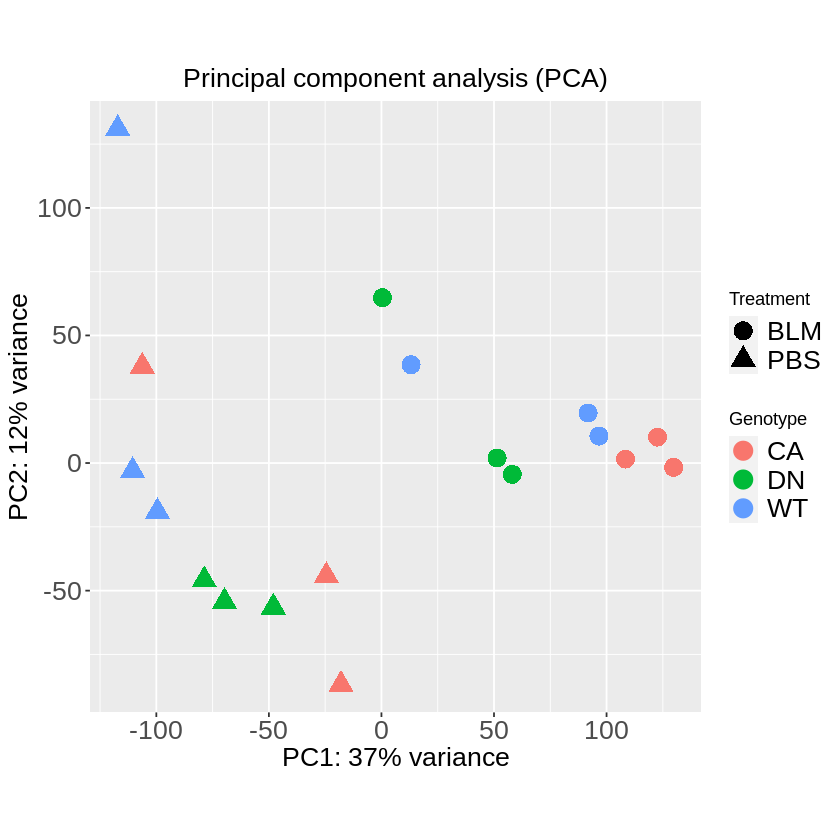

In [14]:
plotPCA(pcaData = pcaData)

### Comparison of PCA plots
Compare the PCA plot that was created here and the one in the article. First important differences are explained variances by both components are different than the reported in the origincal article. There are more differences...

#### Delving more into the code

Let's try to make the plot more similar to the original one and one simple approach would be to have similar ranges of values to the original figure. So, let's set for horizontal and vertixal axes range between -130 to 130.

Initial approach would be to copy the `plotPCA` function above and add an easily recognizable suffix like *_1XX*. Once the code you have written works then you can give it an appropriate name.

In [15]:
plotPCA_1XX <- function(pcaData){
  percentVar=round(100*summary(pca.object)$importance[2,1:2],0)
  p=ggplot(pcaData, aes(PC1, PC2, color=Genotype, shape = Treatment)) + geom_point(size=5) 
  p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
  p=p+ylab(paste0("PC2: ",percentVar[2],"% variance")) 
  p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
    theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
    theme(axis.text.x = element_text( size = 16),
          axis.text.y = element_text( size = 16),
          axis.title.x = element_text( size = 16),
          axis.title.y = element_text( size = 16) ) +
    theme(legend.text=element_text(size=16)) + xlim(-130,130) + ylim(-130,130)
  print(p)
}

Now let's call this function with the same `pcData` object and check the difference in plot as well as the above code.

Warning message:
“Removed 1 rows containing missing values (geom_point).”


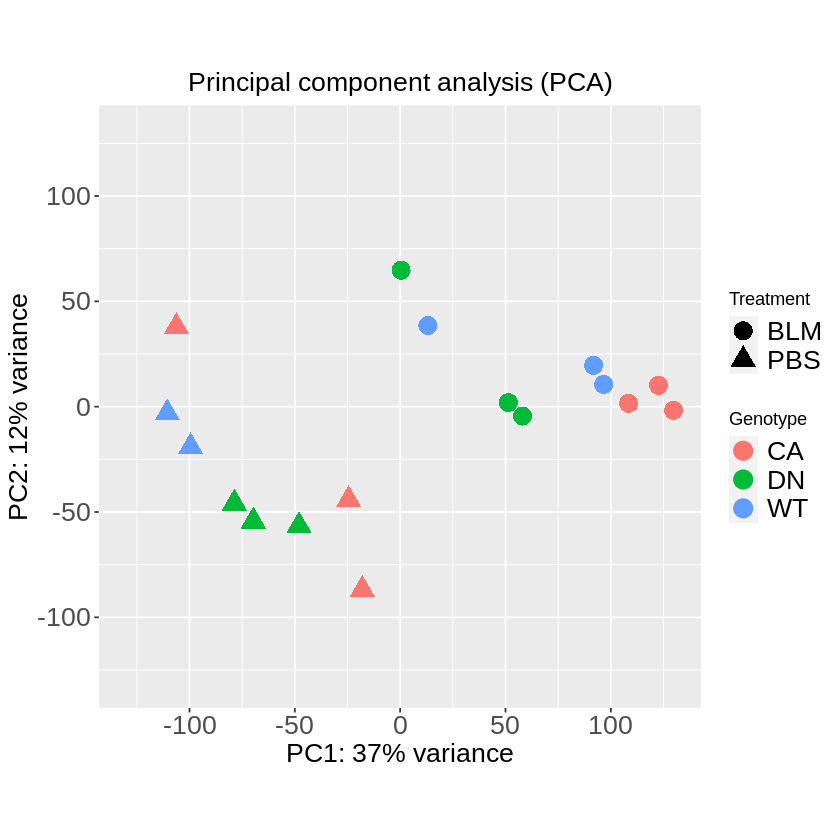

In [16]:
plotPCA_1XX(pcaData = pcaData)

If you noticed there was a warning, but the figure was still produced. The warning was `“Removed 1 rows containing missing values (geom_point).”`. Instead of our new function `plotPCA_1XX` try `plotPCA` function again and compare the results.

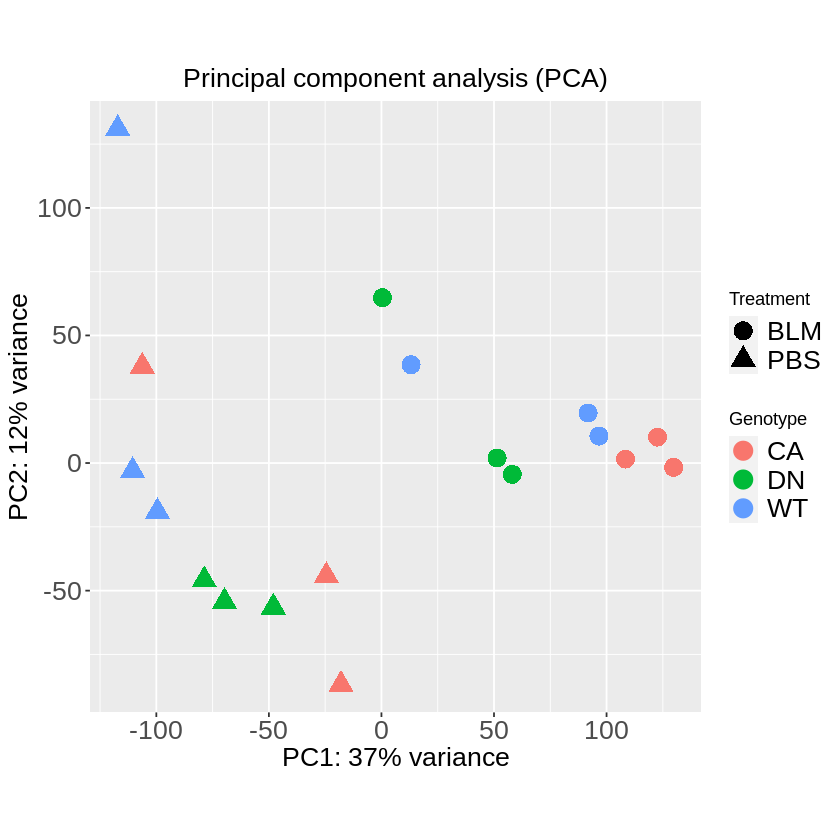

In [17]:
plotPCA(pcaData = pcaData)

Indeed a sample with *Genotype* **WT** and **PBS** *Treatment* was left out. Explain why it was left out.

Let's try now larger values instead of ranges [-130,130] like [-150,150].

In [19]:
plotPCA_2XX <- function(pcaData){
  percentVar=round(100*summary(pca.object)$importance[2,1:2],0)
  p=ggplot(pcaData, aes(PC1, PC2, color=Genotype, shape = Treatment)) + geom_point(size=5) 
  p=p+xlab(paste0("PC1: ",percentVar[1],"% variance")) 
  p=p+ylab(paste0("PC2: ",percentVar[2],"% variance")) 
  p=p+ggtitle("Principal component analysis (PCA)")+coord_fixed(ratio=1.0)+ 
    theme(plot.title = element_text(size = 16,hjust = 0.5)) + theme(aspect.ratio=1) +
    theme(axis.text.x = element_text( size = 16),
          axis.text.y = element_text( size = 16),
          axis.title.x = element_text( size = 16),
          axis.title.y = element_text( size = 16) ) +
    theme(legend.text=element_text(size=16)) + xlim(-150,150) + ylim(-150,150)
  print(p)
}

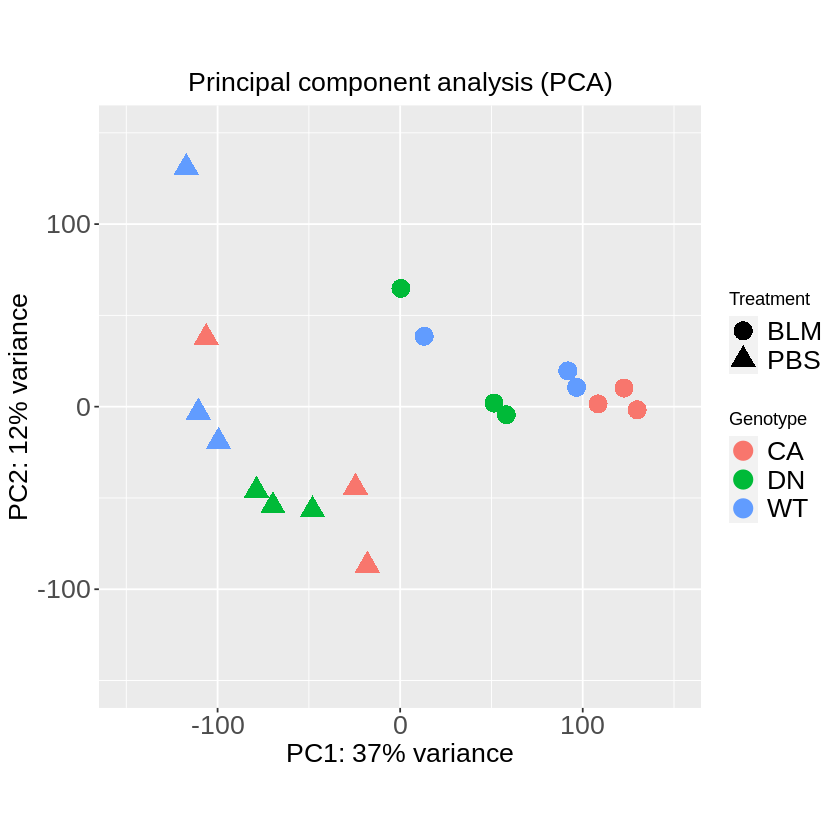

In [20]:
plotPCA_2XX(pcaData = pcaData)

As seen `plotPCA_2XX` didn't give any warning. You can improve on this function, but now let's have a look at the PCA object using R's helper functions like `summary`.

In [21]:
summary(pca.object)

Importance of components:
                           PC1     PC2     PC3      PC4      PC5      PC6
Standard deviation     87.1088 50.3112 46.5837 35.31220 31.78979 30.00559
Proportion of Variance  0.3699  0.1234  0.1058  0.06078  0.04926  0.04388
Cumulative Proportion   0.3699  0.4932  0.5990  0.65979  0.70904  0.75293
                            PC7      PC8      PC9     PC10     PC11     PC12
Standard deviation     27.81320 25.29070 24.04358 22.25522 22.15490 21.14501
Proportion of Variance  0.03771  0.03118  0.02818  0.02414  0.02392  0.02179
Cumulative Proportion   0.79063  0.82181  0.84999  0.87413  0.89806  0.91985
                           PC13     PC14     PC15     PC16     PC17      PC18
Standard deviation     19.85227 18.43591 18.40715 17.38109 16.41521 7.906e-14
Proportion of Variance  0.01921  0.01657  0.01652  0.01473  0.01313 0.000e+00
Cumulative Proportion   0.93906  0.95563  0.97214  0.98687  1.00000 1.000e+00

The above function provides useful metrics, for instance, one can decide how many principal components are needed to capture 70% of variability in data.

#### Session information for reproducing the results
Reproducing results from other researchers doesn't only need public availability of data and software packages, but also correct annotation of software. Thus, used software as well as versions of the used software need to be recorded in addition to data and code.

In [23]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_3.32.1  limma_3.46.0  ggplot2_3.3.3

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6          pillar_1.6.0        compiler_4.0.5     
 [4] BiocManager_1.30.15 base64enc_0.1-3     tools_4.0.5        
 [7] digest_0.6.27       uuid_0.1-4          latti